# Scaling things up

So we have our algorithm (though it's always open to tweaking). The next step is to run it on all galaxies returned from galaxy builder with more than a certain number of classifications.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas
import requests
import json
import os
from tempfile import NamedTemporaryFile
from shapely.geometry import LineString
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.transforms as transforms
import numpy as np
from matplotlib.lines import Line2D
import spiralExtraction

from ipywidgets import FloatProgress
from IPython.display import display

In [3]:
wrapColor = lambda color, s: '{}{}\033[0m'.format(color, s)
red = lambda s: wrapColor('\033[31m', s)
green = lambda s: wrapColor('\033[32m', s)
yellow = lambda s: wrapColor('\033[33m', s)
blue = lambda s: wrapColor('\033[34m', s)
purple = lambda s: wrapColor('\033[35m', s)
print(red('I'), green('really'), yellow('really'), blue('like'), purple('rainbows'))

I really really like rainbows


In [4]:
classifications = pandas.read_csv('../classifications/galaxy-builder-classifications_24-7-18.csv')
subjects = pandas.read_csv('../classifications/galaxy-builder-subjects_24-7-18.csv')
null = None
true = True
false = False

In [5]:
getUrl = lambda id: eval(subjects[subjects['subject_id'] == id]['locations'].iloc[0])['1']

In [6]:
most_recent_workflow = classifications.workflow_version == 61.107
classifications[most_recent_workflow].groupby('subject_ids')
classificationsCounts = classifications[most_recent_workflow]['subject_ids'].value_counts()
subjIds = np.array(classificationsCounts[classificationsCounts > 25].index)

print('Identified {} subjects with more than 25 classifications'.format(purple(subjIds.shape[0])))

Identified 56 subjects with more than 25 classifications


In [7]:
def getDrawnArms(id):
    annotationsForSubject = [
        eval(foo) for foo in 
        classifications[classifications['subject_ids'] == id]['annotations']
    ]
    try:
        annotationsWithSpiral = [
            c[3]['value'][0]['value']
            for c in annotationsForSubject
            if len(c) > 3 and len(c[3]['value'][0]['value'])
        ]
    except IndexError as e:
        print('{} raised {}'.format(id, e))
        assert False
    spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
    spiralsWithLengthCut = [
        [[[p['x'], p['y']] for p in a] for a in c]
        for c in spirals if all([len(a) > 5 for a in c])
    ]
    drawnArms = np.array([
        np.array(arm)
        for classification in spiralsWithLengthCut
        for arm in classification
        if LineString(arm).is_simple
    ])
    return drawnArms

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
/Users/tlingard/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/tlingard/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/tlingard/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/tlingard/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warning

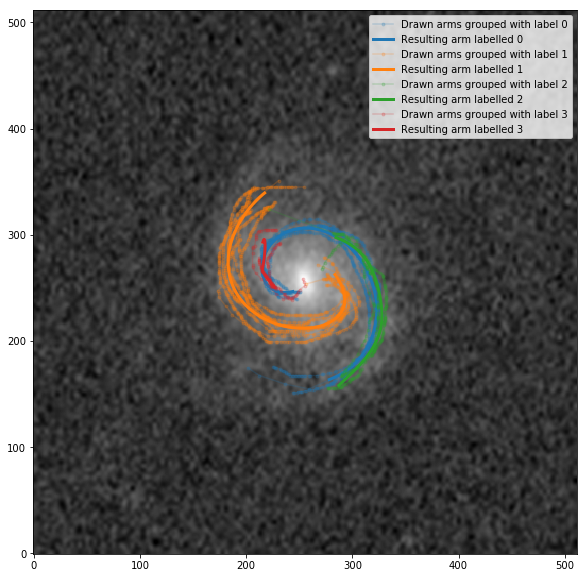

In [30]:
progress = FloatProgress(min=0, max=len(subjIds))
display(progress)

plt.figure(figsize=(10, 10))
for chosenId in subjIds:
    progress.value += 1
    drawnArms = getDrawnArms(chosenId)
    
    functions, labels = spiralExtraction.fit(drawnArms, verbose=False, returnArmLabels=True)
    
    url = getUrl(chosenId)
    imgData = requests.get(url).content
    
    f = NamedTemporaryFile(suffix='.{}'.format(url.split('.')[-1]), delete=False)
    f.write(imgData)
    f.close()
    pic = Image.open(f.name)
    os.unlink(f.name)
    
    plt.clf()
    plt.imshow(pic, cmap='gray', origin='lower')
    for arm in drawnArms:
        lines = plt.plot(
            arm[:, 0],
            arm[:, 1],
            '.-',
            linewidth=1,
            markersize=3,
            label='Drawn arms grouped with label {}'.format(i) if not c else None
        )
    plt.savefig('./cleanedPolylines/subject-{}'.format(chosenId))
    plt.clf()
    plt.imshow(pic, cmap='gray', origin='lower')
    t = np.linspace(0, 1, 1000)
    for i in range(np.max(labels) + 1):
        c = None
        for arm in drawnArms[labels == i]:
            lines = plt.plot(
                arm[:, 0],
                arm[:, 1],
                '.-',
                alpha=0.2,
                color=(c if c else None),
                label='Drawn arms grouped with label {}'.format(i) if not c else None
            )
            c = lines[0].get_color()
            
        Sx, Sy = functions[i]
        plt.plot((Sx(t)+0.5)*512, (Sy(t)+0.5)*512, color=c, linewidth=3, label='Resulting arm labelled {}'.format(i))
    
    plt.legend()
    plt.savefig('./obtainedArms2/subject-{}'.format(chosenId))
    
    np.save('./functions/subject-{}'.format(chosenId), functions)

In [31]:
import os, subprocess
files = os.listdir('./obtainedArms2')
for f in files:
    subprocess.call('montage cleanedPolylines/{0} obtainedArms2/{0} -geometry 1000x1000+2+2 montages/{0}'.format(f), shell=True)